In [3]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

# Load sample image from SA-Lens dataset
img_path = "sample_frames/Screenshot 2025-03-12 005050.png"
orig_img = np.array(Image.open(img_path).convert("RGB"))

def apply_raindrop_overlay(img, drop_count=100, radius_range=(10, 30), blur_ksize=21):
    """
    Simulate raindrop distortion by:
      - Random circular droplets
      - Simple refractive-like jitter inside each droplet
      - Alpha-blending and Gaussian blur for soft edges
    """
    h, w = img.shape[:2]
    overlay = np.zeros_like(img, dtype=np.float32)
    alpha = np.zeros((h, w), dtype=np.float32)

    for _ in range(drop_count):
        # random droplet parameters
        r = np.random.randint(radius_range[0], radius_range[1])
        cx = np.random.randint(r, w - r)
        cy = np.random.randint(r, h - r)

        # create circular mask
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.circle(mask, (cx, cy), r, 255, -1)

        # get coordinates inside droplet
        ys, xs = np.where(mask == 255)
        # refractive jitter proportional to radius
        jitter_x = np.random.uniform(-0.1*r, 0.1*r, size=ys.shape)
        jitter_y = np.random.uniform(-0.1*r, 0.1*r, size=ys.shape)
        map_x = (xs + jitter_x).astype(np.float32)
        map_y = (ys + jitter_y).astype(np.float32)

        # remap pixels under droplet
        warped = cv2.remap(img, map_x.reshape(-1,1), map_y.reshape(-1,1),
                           interpolation=cv2.INTER_LINEAR).reshape(-1,3)
        overlay[ys, xs] = warped
        alpha[ys, xs] = 1.0

    # soften droplet edges
    overlay = cv2.GaussianBlur(overlay, (blur_ksize, blur_ksize), 0)
    alpha = cv2.GaussianBlur(alpha, (blur_ksize, blur_ksize), 0)[..., None]

    # composite final image
    out = img.astype(np.float32) * (1 - alpha) + overlay * alpha
    return np.clip(out, 0, 255).astype(np.uint8)


# snell-law refraction simulation

def apply_snell_law_raindrop_overlay(img,
                           drop_count=100,
                           radius_range=(10, 30),
                           blur_ksize=21,
                           refractive_idx=1.33):
    """
    Simulate raindrop distortion with:
      - Random ellipsoidal droplets
      - Snell‐law refraction inside each droplet
      - Alpha‐blend + Gaussian blur for soft edges
    """
    h, w = img.shape[:2]
    overlay = np.zeros_like(img, dtype=np.float32)
    alpha   = np.zeros((h, w),       dtype=np.float32)

    for _ in range(drop_count):
        # 1) random ellipse params
        ry = np.random.randint(radius_range[0], radius_range[1])
        rx = np.random.randint(radius_range[0], radius_range[1])
        cx = np.random.randint(rx, w - rx)
        cy = np.random.randint(ry, h - ry)
        angle = np.random.uniform(0, 360)

        # 2) draw ellipse mask
        mask = np.zeros((h, w), dtype=np.uint8)
        cv2.ellipse(mask,
                    center=(cx, cy),
                    axes=(rx, ry),
                    angle=angle,
                    startAngle=0,
                    endAngle=360,
                    color=255,
                    thickness=-1)

        # 3) compute refraction disp via Snell-law approx
        ys, xs = np.where(mask == 255)
        dx = xs.astype(np.float32) - cx
        dy = ys.astype(np.float32) - cy
        disp_x = dx * (1 - 1/refractive_idx)
        disp_y = dy * (1 - 1/refractive_idx)
        map_x = (xs + disp_x).astype(np.float32)
        map_y = (ys + disp_y).astype(np.float32)

        # 4) remap & write into overlay+alpha
        warped = cv2.remap(img,
                           map_x.reshape(-1,1),
                           map_y.reshape(-1,1),
                           interpolation=cv2.INTER_LINEAR
                          ).reshape(-1,3)
        overlay[ys, xs] = warped
        alpha[ys, xs]   = 1.0

    # 5) soften droplet edges
    overlay = cv2.GaussianBlur(overlay, (blur_ksize, blur_ksize), 0)
    alpha   = cv2.GaussianBlur(alpha,   (blur_ksize, blur_ksize), 0)[..., None]

    # 6) composite
    out = img.astype(np.float32)*(1 - alpha) + overlay*alpha
    return np.clip(out, 0, 255).astype(np.uint8)



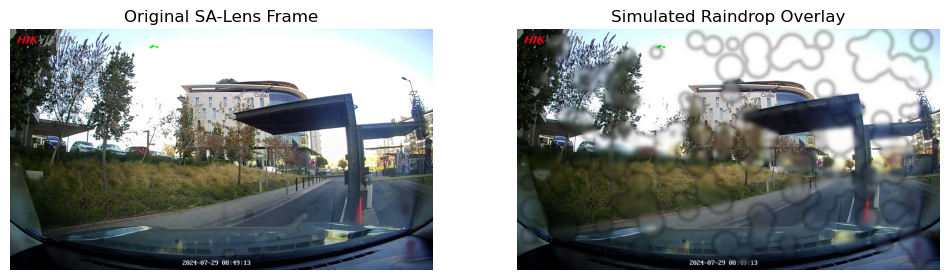

In [2]:
# Apply demo distortion
aug_img = apply_raindrop_overlay(orig_img, drop_count=150, radius_range=(15, 40), blur_ksize=31)

# Display results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(orig_img)
axes[0].set_title("Original SA-Lens Frame")
axes[0].axis("off")
axes[1].imshow(aug_img)
axes[1].set_title("Simulated Raindrop Overlay")
axes[1].axis("off")
plt.show()


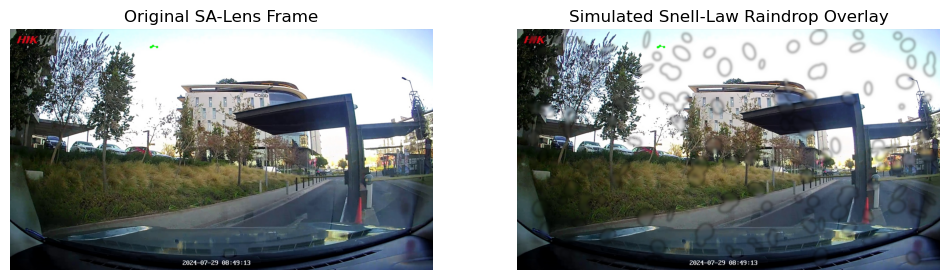

In [6]:
aug_img = apply_snell_law_raindrop_overlay(orig_img, drop_count=150, radius_range=(6, 25), blur_ksize=21)
# Display results
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(orig_img)
axes[0].set_title("Original SA-Lens Frame")
axes[0].axis("off")
axes[1].imshow(aug_img)
axes[1].set_title("Simulated Snell-Law Raindrop Overlay")
axes[1].axis("off")
plt.show()